In [27]:
!pip install pymongo
!pip install faker
!pip install unidecode
!pip install pandas
!pip install openpyxl
!pip install apyori
!pip install ipywidgets
!pip install prophet

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached prophet-1.1.5-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.5 kB)
  Using cached cmdstanpy-1.2.2-py3-none-any.whl.metadata (4.1 kB)
  Using cached holidays-0.48-py3-none-any.whl.metadata (23 kB)
  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
  Using cached importlib_resources-6.4.0-py3-none-any.whl.metadata (3.9 kB)
  Using

In [2]:
from pymongo import MongoClient
from datetime import datetime
import pandas as pd

### MongoDB

In [3]:
uri = 'mongodb://localhost/'
db = MongoClient(uri)['vendas']

# Recomendação de produtos - Algoritmos Apriori

In [12]:
# db['venda_estoque'].find()

# estoques = {}
# for e in db['venda_estoque'].find():
#   estoques[f"P{e['id']:02}"] = e
# estoques



In [15]:
# dados de 1 ano
d = datetime.now()
cur = db['venda_pedido'].find({'horario':  {'$gte': datetime(d.year - 1, d.month, d.day)}})

qtd = db['venda_estoque'].count_documents({})
pedi = []
for ped in cur:
  itens = []
  for prod in ped['itens_pedido']:
    id = prod['id']
    while len(itens) < id - 1: itens.append(' - ')
    itens.append(f'P{id:02}')
  while len(itens) < qtd: itens.append(' - ')
  pedi.append(itens)

In [16]:
# visualizar
for a in pedi:
  print(a)

[' - ', ' - ', 'P03', ' - ', ' - ', ' - ', ' - ', ' - ', 'P09', ' - ', 'P11', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', 'P28', ' - ']
[' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', 'P28', ' - ']
[' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', 'P08', ' - ', 'P10', ' - ', ' - ', ' - ', ' - ', 'P15', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ']
[' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', 'P09', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ']
[' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', 'P21', ' - ', 'P23', ' - ', ' - ', ' - ', '

In [17]:
from apyori import apriori
# regras = list(apriori(pedi, min_support = 0.0006, min_confidence = 0.3, min_lift = 1))
# regras = list(apriori(pedi, min_support = 0.001, min_confidence = 0.1, min_lift = 1))
regras = list(apriori(pedi, min_support = 0.0007, min_confidence = 0.1, min_lift = 1))
# regras = list(apriori(pedi, min_support = 0.0001, min_confidence = 0, min_lift = 0))
# regras = list(apriori(pedi, min_support = 0.00069, min_confidence = 0, min_lift = 0))

it_a = []
it_b = []
# rule = []
supo = []
conf = []
lift = []
for regra in regras:
  for item in regra[2]:
    if ' - ' not in item[0] and ' - ' not in item[1]:
      # rule.append(f"{', '.join(item[0])} > {', '.join(item[1])}")
      it_a.append(','.join(sorted(item[0])))
      it_b.append(','.join(sorted(item[1])))
      supo.append(regra[1])
      conf.append(item[2])
      lift.append(item[3])

df_apriori = pd.DataFrame({
  'item_a': it_a, 
  'item_b': it_b, 
  # 'regra': rule, 
  'suporte': supo, 
  'confianca': conf, 
  'lift': lift
}).sort_values(
  by = ['lift', 'confianca', 'suporte'], 
  ascending = False).reset_index()
df_apriori


,index,item_a,item_b,suporte,confianca,lift
0,1061,"P10,P16","P15,P24",0.001131,0.285714,63.178571
1,1064,"P15,P24","P10,P16",0.001131,0.250000,63.178571
2,1041,"P08,P15","P10,P29",0.001131,0.285714,56.158730
3,1044,"P10,P29","P08,P15",0.001131,0.222222,56.158730
4,1065,"P16,P24","P10,P15",0.001131,0.333333,39.311111
...,...,...,...,...,...,...
1065,53,P22,P10,0.003957,0.102941,1.131074
1066,51,P11,P10,0.007349,0.100000,1.098758
1067,34,P26,P05,0.006218,0.104762,1.083765
1068,29,P09,P05,0.009045,0.101911,1.054270


In [73]:
i = 0
j = i + 60
df_apriori[i:j]

,index,item_a,item_b,suporte,confianca,lift
0,1064,"P15,P24","P10,P16",0.001132,0.250000,63.107143
1,1061,"P10,P16","P15,P24",0.001132,0.285714,63.107143
2,1041,"P08,P15","P10,P29",0.001132,0.285714,56.095238
3,1044,"P10,P29","P08,P15",0.001132,0.222222,56.095238
4,1065,"P16,P24","P10,P15",0.001132,0.333333,39.266667
5,1060,"P10,P15","P16,P24",0.001132,0.133333,39.266667
6,1030,"P07,P08","P11,P29",0.001132,0.222222,35.696970
7,1052,"P10,P29","P14,P15",0.001132,0.222222,35.696970
8,1035,"P11,P29","P07,P08",0.001132,0.181818,35.696970
9,1053,"P14,P15","P10,P29",0.001132,0.181818,35.696970


In [74]:
df_apriori.to_dict('records')

[{'index': 1064,
  'item_a': 'P15,P24',
  'item_b': 'P10,P16',
  'suporte': 0.0011318619128466328,
  'confianca': 0.25,
  'lift': 63.107142857142854},
 {'index': 1061,
  'item_a': 'P10,P16',
  'item_b': 'P15,P24',
  'suporte': 0.0011318619128466328,
  'confianca': 0.2857142857142857,
  'lift': 63.10714285714285},
 {'index': 1041,
  'item_a': 'P08,P15',
  'item_b': 'P10,P29',
  'suporte': 0.0011318619128466328,
  'confianca': 0.2857142857142857,
  'lift': 56.09523809523809},
 {'index': 1044,
  'item_a': 'P10,P29',
  'item_b': 'P08,P15',
  'suporte': 0.0011318619128466328,
  'confianca': 0.2222222222222222,
  'lift': 56.09523809523809},
 {'index': 1065,
  'item_a': 'P16,P24',
  'item_b': 'P10,P15',
  'suporte': 0.0011318619128466328,
  'confianca': 0.33333333333333337,
  'lift': 39.26666666666667},
 {'index': 1060,
  'item_a': 'P10,P15',
  'item_b': 'P16,P24',
  'suporte': 0.0011318619128466328,
  'confianca': 0.13333333333333333,
  'lift': 39.266666666666666},
 {'index': 1030,
  'item_a

In [18]:
db['venda_apriori'].delete_many({})
db['venda_apriori'].insert_many(df_apriori.to_dict('records'))

InsertManyResult([ObjectId('6643f8990dd51802d60b3297'), ObjectId('6643f8990dd51802d60b3298'), ObjectId('6643f8990dd51802d60b3299'), ObjectId('6643f8990dd51802d60b329a'), ObjectId('6643f8990dd51802d60b329b'), ObjectId('6643f8990dd51802d60b329c'), ObjectId('6643f8990dd51802d60b329d'), ObjectId('6643f8990dd51802d60b329e'), ObjectId('6643f8990dd51802d60b329f'), ObjectId('6643f8990dd51802d60b32a0'), ObjectId('6643f8990dd51802d60b32a1'), ObjectId('6643f8990dd51802d60b32a2'), ObjectId('6643f8990dd51802d60b32a3'), ObjectId('6643f8990dd51802d60b32a4'), ObjectId('6643f8990dd51802d60b32a5'), ObjectId('6643f8990dd51802d60b32a6'), ObjectId('6643f8990dd51802d60b32a7'), ObjectId('6643f8990dd51802d60b32a8'), ObjectId('6643f8990dd51802d60b32a9'), ObjectId('6643f8990dd51802d60b32aa'), ObjectId('6643f8990dd51802d60b32ab'), ObjectId('6643f8990dd51802d60b32ac'), ObjectId('6643f8990dd51802d60b32ad'), ObjectId('6643f8990dd51802d60b32ae'), ObjectId('6643f8990dd51802d60b32af'), ObjectId('6643f8990dd51802d60b32

# Predição com Prophet

In [19]:
# # dados de 1 ano
# d = datetime.now()
# cur = db['venda_pedido'].find({'horario':  {'$gte': datetime(d.year - 1, d.month, d.day)}})
cur = db['venda_pedido'].find()

df_prophet = pd.DataFrame(cur)[['horario', 'total']].rename(columns={'horario': 'ds', 'total': 'y'}).sort_values(['ds'])
df_prophet

,ds,y
3,2021-01-01 09:38:00.000,8830.80
2,2021-01-01 11:25:00.000,59732.14
0,2021-01-01 13:02:00.000,7295.82
1,2021-01-01 17:17:00.000,17397.38
4,2021-01-01 17:45:00.000,50569.44
...,...,...
5880,2024-05-13 14:08:00.000,2988.00
5881,2024-05-13 16:19:00.000,10416.80
5884,2024-05-13 19:48:00.000,60603.22
5886,2024-05-14 23:26:35.830,5618.20


In [20]:
from prophet import Prophet

m = Prophet()
m.fit(df_prophet)

Importing plotly failed. Interactive plots will not work.
20:49:58 - cmdstanpy - INFO - Chain [1] start processing
20:49:59 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
6248,2025-05-10 23:26:51.555
6249,2025-05-11 23:26:51.555
6250,2025-05-12 23:26:51.555
6251,2025-05-13 23:26:51.555
6252,2025-05-14 23:26:51.555


In [22]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
6248,2025-05-10 23:26:51.555,14636.642456,-4446.238147,34247.543223
6249,2025-05-11 23:26:51.555,14356.023733,-4475.679846,32966.634708
6250,2025-05-12 23:26:51.555,13678.826428,-6576.594763,33017.170488
6251,2025-05-13 23:26:51.555,13818.438457,-5676.174583,34017.338069
6252,2025-05-14 23:26:51.555,14767.112458,-4630.394814,34664.988402


/home/oscar/.local/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/oscar/.local/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


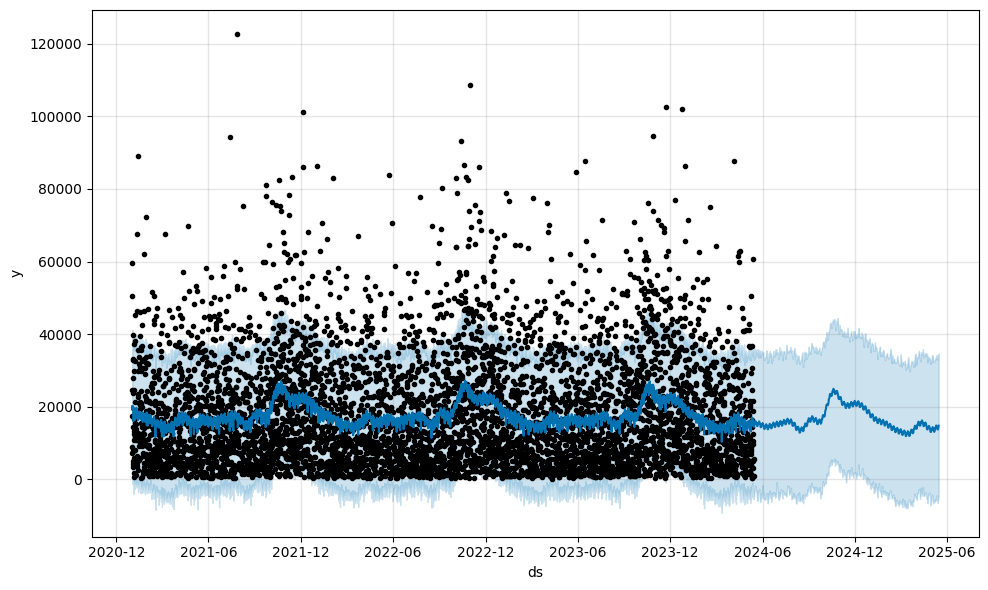

In [23]:
fig1 = m.plot(forecast)

/home/oscar/.local/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/oscar/.local/lib/python3.10/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/home/oscar/.local/lib/python3.10/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the o

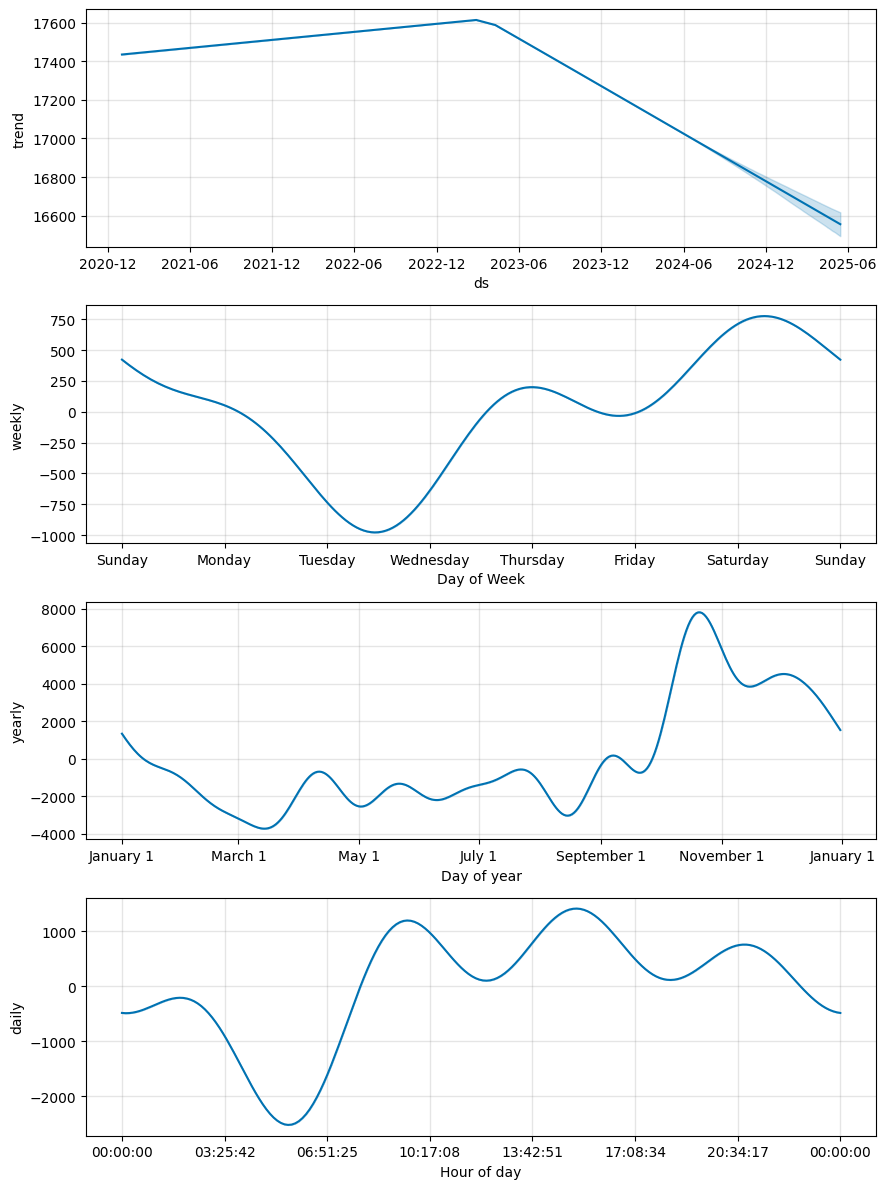

In [24]:
fig2 = m.plot_components(forecast)

In [25]:
fig1.savefig('../home/static/fig1.png')
fig2.savefig('../home/static/fig2.png')